In [ ]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import load_img, img_to_array

In [2]:
batch_size = 8
shape=100
#augmentation for training
train_datagen = ImageDataGenerator(
        rotation_range=40,
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'C:\\Users\\Albatol Ihab\\project\\train',
        target_size=(shape, shape),  
        batch_size=batch_size,
        class_mode='binary',
        subset='training') 

valid_generator = train_datagen.flow_from_directory(
    directory='C:\\Users\\Albatol Ihab\\project\\train',
    target_size=(100, 100),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
        'C:\\Users\\Albatol Ihab\\project\\test',
        target_size=(shape, shape),
        batch_size=batch_size,
        class_mode=None)

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Found 20 images belonging to 1 classes.


In [3]:
#building the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100,3)),
  tf.keras.layers.Dense(units=10, activation='relu'),
  
  tf.keras.layers.Dense(units=20, activation='relu'),
  tf.keras.layers.Dense(units=35, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='relu'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

In [4]:
#Defining the loss function and optimzer
loss= tf.losses.binary_crossentropy
model.compile(loss=loss,optimizer="adam",metrics=['accuracy'])

In [5]:
#Training the model
history=model.fit(
        train_generator,
        epochs=15,
        validation_data=valid_generator,
        steps_per_epoch = train_generator.n//train_generator.batch_size) 

Epoch 1/15
10/10 [==============================] - 2s 93ms/step - loss: 0.7920 - accuracy: 0.5250 - val_loss: 0.7473 - val_accuracy: 0.5000
Epoch 2/15
10/10 [==============================] - 1s 59ms/step - loss: 0.6540 - accuracy: 0.6875 - val_loss: 0.7880 - val_accuracy: 0.5000
Epoch 3/15
10/10 [==============================] - 1s 52ms/step - loss: 0.5355 - accuracy: 0.8125 - val_loss: 0.5323 - val_accuracy: 0.8000
Epoch 4/15
10/10 [==============================] - 1s 77ms/step - loss: 0.4849 - accuracy: 0.8625 - val_loss: 0.4807 - val_accuracy: 0.8500
Epoch 5/15
10/10 [==============================] - 1s 64ms/step - loss: 0.3847 - accuracy: 0.8250 - val_loss: 0.3941 - val_accuracy: 0.8500
Epoch 6/15
10/10 [==============================] - 1s 52ms/step - loss: 0.3028 - accuracy: 0.9375 - val_loss: 0.4785 - val_accuracy: 0.7500
Epoch 7/15
10/10 [==============================] - 1s 52ms/step - loss: 0.2740 - accuracy: 0.8875 - val_loss: 0.4399 - val_accuracy: 0.8500
Epoch 8/15
10

In [6]:
#model.save('feed.h5') 

In [ ]:
print(history.history.keys())

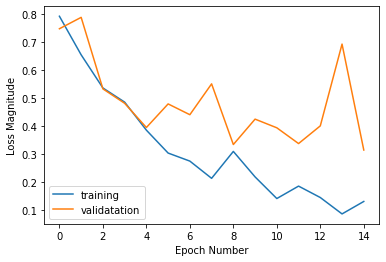

In [7]:
# Make a plot for the loss
plt.xlabel('Epoch Number')
plt.ylabel("Loss Magnitude")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validatation'])

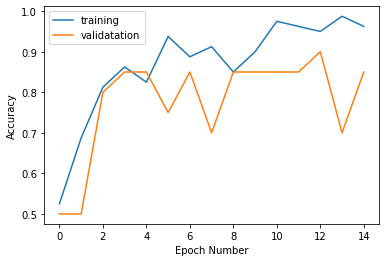

In [8]:
# Make a plot for the accuracy
plt.xlabel('Epoch Number')
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validatation'])

In [ ]:
#Loading testing images for prediction and display it with its label
test_image = load_img('C:\\Users\\Albatol Ihab\\project\\test\\predict\\20230602_150203.jpg', target_size = (shape, shape))
plt.imshow(test_image)
plt.show()
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
if result <0.5:
    print('Apple')
elif result > 0.5:
    print('banana')
else: 
    print('none')

In [ ]:
# Open the camera
vid = cv2.VideoCapture(0)
print("Camera connection successfully established")

while(True):  
    # Capture the frame from camera
    r, frame = vid.read() 
    cv2.imshow('frame', frame)
    
    # Save the frame to disk
    cv2.imwrite('C:\\Users\\Albatol Ihab\\project\\preview.jpg', frame)
    
    # Load the saved image and preprocess it
    test_image = load_img('C:\\Users\\Albatol Ihab\\project\\preview.jpg', target_size = (shape, shape))
    test_image = img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    
    # Get the predicted label and draw a bounding box around the object
    label = ""
    if result[0][0] >0.5:
        print("I saw a banana")
        label = "banana"
        color = (0, 255, 0)  # green color for banana
    elif result[0][0] < 0.5:
        print("I saw an apple")
        label = "apple"
        color = (0, 0, 255)  # red color for apple
    else:
        label = "unknown"
        color = (255, 0, 0)  # blue color for unknown object
        
    # Get the coordinates of the object in the image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)
    edged = cv2.Canny(gray, 50, 150)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the bounding box and label on the frame
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w > 20 and h > 20:
            cv2.putText(frame, label,(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            break
    
    cv2.imshow('frame', frame)
    
    # Remove the saved image from disk
    os.remove('C:\\Users\\Albatol Ihab\\project\\preview.jpg')
    
    # Exit the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

# Release the camera and close all windows
vid.release() 
cv2.destroyAllWindows()